<a href="https://colab.research.google.com/github/BaiganKing/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/Copy_of_LS_DS6_113_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

X Variable: 
- predictor
- explanatory variable
- feature
- independent variable

Y Variable:
- predicted variable
- explained variable
- target
- dependent variable

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

In [0]:
import numpy as np
dir(np.random)

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(2500):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(7500):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users)

[User(purchased=True, time_on_site=234.23821121184804, mobile=True), User(purchased=False, time_on_site=416.74967043165196, mobile=False), User(purchased=True, time_on_site=241.16235696491248, mobile=True), User(purchased=True, time_on_site=411.8397511716441, mobile=False), User(purchased=False, time_on_site=75.3312437333078, mobile=True), User(purchased=False, time_on_site=93.24590384559897, mobile=True), User(purchased=True, time_on_site=54.67000083040827, mobile=True), User(purchased=False, time_on_site=279.3140832055173, mobile=True), User(purchased=True, time_on_site=229.23328152435343, mobile=False), User(purchased=True, time_on_site=465.0029791699171, mobile=False), User(purchased=False, time_on_site=455.72906760129246, mobile=False), User(purchased=False, time_on_site=141.6111280973264, mobile=True), User(purchased=True, time_on_site=285.35942886903064, mobile=False), User(purchased=True, time_on_site=14.100147867049577, mobile=True), User(purchased=True, time_on_site=16.043327

In [0]:
!pip freeze

In [0]:
!pip install pandas==0.23.4

     |████████████████████████████████| 8.9MB 5.0MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=0.24.0, but you'll have pandas 0.23.4 which is incompatible.
  Found existing installation: pandas 0.24.2
    Uninstalling pandas-0.24.2:
      Successfully uninstalled pandas-0.24.2


In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,234.238211,True
1,False,416.749670,False
2,True,241.162357,True
3,True,411.839751,False
4,False,75.331244,True


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.044994865148051,5.062435108072614,5.081736106061906,5.147168837994579,5.147852633953633,5.181521126416139,5.192011119174508,5.239928257590038,5.294134949849264,5.322147454995715,5.371582246024794,5.4134278362258765,5.457561412701911,5.474423030467426,5.483611825523421,5.492524346914686,5.506895922796098,5.5382812598547195,5.557848585705835,5.578142797716911,5.587377879226204,5.597985219737237,5.738161762100628,5.815447471677413,5.843778050573451,5.881855502465893,5.911128615440704,5.990430058173292,5.997137937344851,6.036390204323782,6.038064630611662,6.065961298933825,6.087590808345073,6.089576580614708,6.119826808305413,6.152072814783044,6.191639713714356,6.318281102905164,6.335649188560762,6.344313706732407,...,589.651658858645,590.1658559233597,591.033301527137,591.4395724932466,591.7635906834395,592.0367870470677,592.089225969135,592.142641099694,592.489530406305,592.7765718288961,592.9969172814883,593.034197303646,593.12218192242,593.1228736552924,593.1455882718295,593.1888091960789,593.4197879096624,593.620255277723,593.6270584651228,593.7169285358892,593.9029955091976,593.9694186787951,594.0313109656453,594.4252956832955,594.5557663715208,595.1450970485517,595.2675413230328,595.7374449054556,596.2076339647804,597.1595093491238,597.4259144831892,597.4615806388664,597.9446552931173,598.1787038307767,598.3730235592137,598.439470210336,598.5544844569342,599.2912534979891,599.6472736067761,599.8792293115033
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,0,1,0,0,1,1,0,0,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,1,...,1,1,1,1,0,1,1,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0,1,1,0,0,1,1,0,1
True,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,...,0,0,0,0,1,0,0,1,1,1,0,0,0,0,1,0,0,1,1,0,1,1,0,1,0,0,1,0,1,1,1,1,0,0,1,1,0,0,1,0


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 6)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.45, 104.184]","(104.184, 203.323]","(203.323, 302.462]","(302.462, 401.601]","(401.601, 500.74]","(500.74, 599.879]"
purchased,,,,,,
False,2059,1800,1598,283,282,229
True,875,1065,1285,168,174,182


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.45, 104.184]","(104.184, 203.323]","(203.323, 302.462]","(302.462, 401.601]","(401.601, 500.74]","(500.74, 599.879]"
purchased,,,,,,
False,0.701772,0.628272,0.554284,0.627494,0.618421,0.557178
True,0.298228,0.371728,0.445716,0.372506,0.381579,0.442822


In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.6976,0.600933
True,0.3024,0.399067


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

ct = pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins], normalize='index')
ct

purchased              False        ...                    True 
time_on_site (4.45, 104.184]        ...        (500.74, 599.879]
mobile                              ...                         
False               0.135200        ...                   0.0728
True                0.229467        ...                   0.0000

[2 rows x 12 columns]

In [0]:
type(ct)

pandas.core.frame.DataFrame

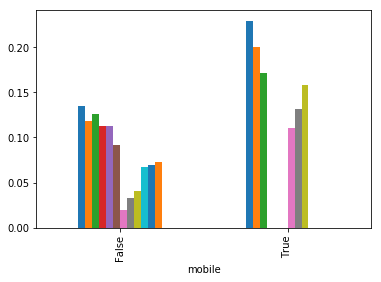

In [0]:
ct.plot(kind='bar', legend=False);

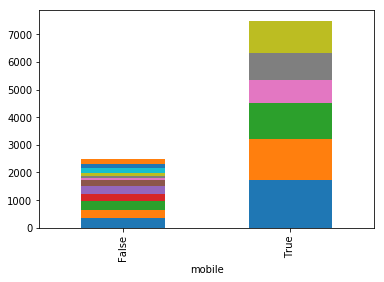

In [0]:
ct = pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins])

ct.plot(kind='bar', stacked=True, legend=False);

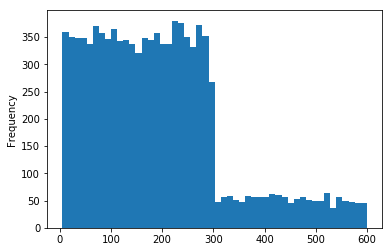

In [0]:
user_data['time_on_site'].plot.hist(bins=50);

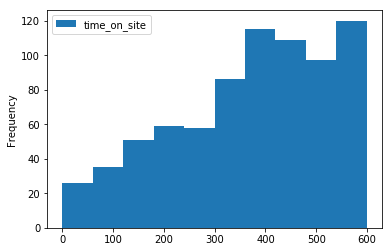

In [0]:
user_data[(user_data['mobile']==False) & (user_data['purchased']==True)].plot.hist()

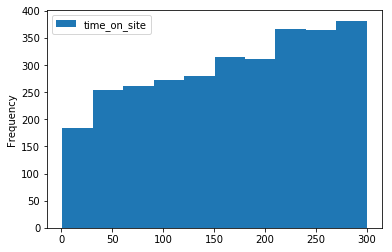

In [0]:
user_data[(user_data['mobile']==True) & (user_data['purchased']==True)].plot.hist()

In [0]:
pt = pd.pivot_table(user_data, values='purchased', index=time_bins)
pt

,purchased
time_on_site,
"(4.45, 104.184]",0.298228
"(104.184, 203.323]",0.371728
"(203.323, 302.462]",0.445716
"(302.462, 401.601]",0.372506
"(401.601, 500.74]",0.381579
"(500.74, 599.879]",0.442822


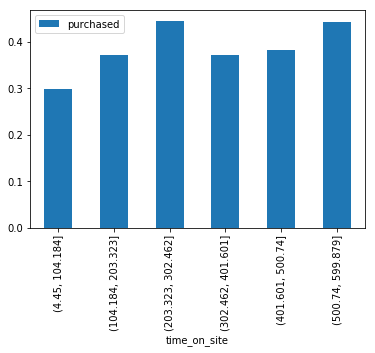

In [0]:
pt.plot.bar()

In [0]:
ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
                 normalize='columns')
ct

purchased              False               True           
mobile                 False     True      False     True 
time_on_site                                              
(4.45, 104.184]     0.193807  0.381850  0.064815  0.275977
(104.184, 203.323]  0.169725  0.333703  0.107143  0.328767
(203.323, 302.462]  0.181193  0.284446  0.134921  0.395256
(302.462, 401.601]  0.162271  0.000000  0.222222  0.000000
(401.601, 500.74]   0.161697  0.000000  0.230159  0.000000
(500.74, 599.879]   0.131307  0.000000  0.240741  0.000000

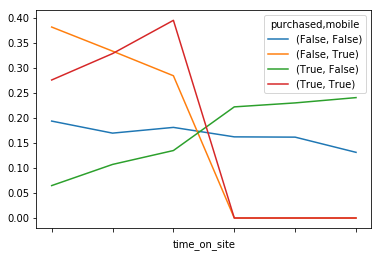

In [0]:
ct.plot();

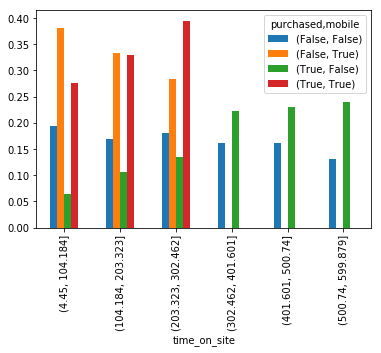

In [0]:
ct.plot(kind='bar');

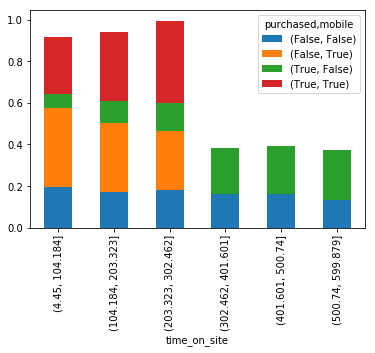

In [0]:
ct.plot(kind='bar', stacked=True);

In [0]:
ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
                 normalize='columns')
ct

purchased              False               True           
mobile                 False     True      False     True 
time_on_site                                              
(4.45, 104.184]     0.193807  0.381850  0.064815  0.275977
(104.184, 203.323]  0.169725  0.333703  0.107143  0.328767
(203.323, 302.462]  0.181193  0.284446  0.134921  0.395256
(302.462, 401.601]  0.162271  0.000000  0.222222  0.000000
(401.601, 500.74]   0.161697  0.000000  0.230159  0.000000
(500.74, 599.879]   0.131307  0.000000  0.240741  0.000000

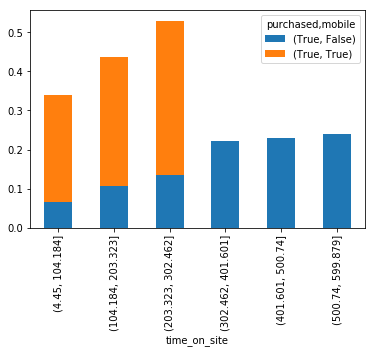

In [0]:
ct_sliced = ct.iloc[:, [2,3]]

ct_sliced.plot(kind='bar', stacked=True);

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

In [2]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/BaiganKing/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv", index_col=[0])
df.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [0]:
age_bins = pd.cut(df['age'], 4)
weight_bins = pd.cut(df['weight'], 4)
weight = df['weight']
excercise_time = df['exercise_time']
age = df['age']

In [65]:
pd.crosstab(age_bins, excercise_time )

exercise_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,296,297,298,299,300
age,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"(17.938, 33.5]",2,0,1,2,0,0,2,1,0,2,1,1,0,0,0,1,1,1,0,1,1,1,2,0,1,0,0,0,3,2,2,0,1,1,2,3,2,3,0,2,...,1,1,2,1,2,2,1,1,0,0,1,1,0,1,0,0,1,0,0,2,3,1,2,0,0,1,0,1,0,2,0,2,1,2,1,2,1,0,1,1
"(33.5, 49.0]",0,2,1,1,2,3,0,0,0,1,1,0,1,3,0,1,0,2,3,0,1,3,1,0,1,1,0,2,0,0,0,1,2,1,2,2,1,0,0,1,...,2,1,1,3,1,2,1,0,1,1,3,0,1,1,2,0,1,3,1,0,2,1,1,1,2,0,0,2,1,5,0,0,1,1,0,2,2,2,0,1
"(49.0, 64.5]",0,2,1,3,0,2,2,0,0,0,2,0,0,3,2,0,1,3,0,0,0,0,1,1,1,1,1,1,1,2,3,1,3,0,1,1,0,0,0,0,...,0,2,1,0,1,1,1,3,0,0,2,0,0,1,1,1,3,3,2,1,1,0,1,0,1,1,1,2,2,0,1,1,0,0,0,0,1,4,1,3
"(64.5, 80.0]",0,0,4,0,3,2,2,0,3,0,2,0,1,0,1,3,3,5,3,4,3,8,3,1,2,1,1,3,2,3,3,1,0,4,2,1,2,2,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [66]:
pd.crosstab(age_bins, excercise_time, normalize ='columns' )

exercise_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,296,297,298,299,300
age,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"(17.938, 33.5]",1.0,0.0,0.142857,0.333333,0.0,0.000000,0.333333,1.0,0.0,0.666667,0.166667,1.0,0.0,0.0,0.000000,0.2,0.2,0.090909,0.0,0.2,0.2,0.083333,0.285714,0.0,0.2,0.000000,0.0,0.000000,0.500000,0.285714,0.250,0.000000,0.166667,0.166667,0.285714,0.428571,0.4,0.6,0.0,0.50,...,0.333333,0.25,0.50,0.25,0.50,0.4,0.333333,0.25,0.0,0.0,0.166667,1.0,0.0,0.333333,0.000000,0.0,0.2,0.0,0.000000,0.666667,0.500000,0.5,0.50,0.0,0.000000,0.5,0.0,0.2,0.000000,0.285714,0.0,0.666667,0.5,0.666667,1.0,0.5,0.25,0.000000,0.5,0.2
"(33.5, 49.0]",0.0,0.5,0.142857,0.166667,0.4,0.428571,0.000000,0.0,0.0,0.333333,0.166667,0.0,0.5,0.5,0.000000,0.2,0.0,0.181818,0.5,0.0,0.2,0.250000,0.142857,0.0,0.2,0.333333,0.0,0.333333,0.000000,0.000000,0.000,0.333333,0.333333,0.166667,0.285714,0.285714,0.2,0.0,0.0,0.25,...,0.666667,0.25,0.25,0.75,0.25,0.4,0.333333,0.00,1.0,1.0,0.500000,0.0,1.0,0.333333,0.666667,0.0,0.2,0.5,0.333333,0.000000,0.333333,0.5,0.25,1.0,0.666667,0.0,0.0,0.4,0.333333,0.714286,0.0,0.000000,0.5,0.333333,0.0,0.5,0.50,0.333333,0.0,0.2
"(49.0, 64.5]",0.0,0.5,0.142857,0.500000,0.0,0.285714,0.333333,0.0,0.0,0.000000,0.333333,0.0,0.0,0.5,0.666667,0.0,0.2,0.272727,0.0,0.0,0.0,0.000000,0.142857,0.5,0.2,0.333333,0.5,0.166667,0.166667,0.285714,0.375,0.333333,0.500000,0.000000,0.142857,0.142857,0.0,0.0,0.0,0.00,...,0.000000,0.50,0.25,0.00,0.25,0.2,0.333333,0.75,0.0,0.0,0.333333,0.0,0.0,0.333333,0.333333,1.0,0.6,0.5,0.666667,0.333333,0.166667,0.0,0.25,0.0,0.333333,0.5,1.0,0.4,0.666667,0.000000,1.0,0.333333,0.0,0.000000,0.0,0.0,0.25,0.666667,0.5,0.6
"(64.5, 80.0]",0.0,0.0,0.571429,0.000000,0.6,0.285714,0.333333,0.0,1.0,0.000000,0.333333,0.0,0.5,0.0,0.333333,0.6,0.6,0.454545,0.5,0.8,0.6,0.666667,0.428571,0.5,0.4,0.333333,0.5,0.500000,0.333333,0.428571,0.375,0.333333,0.000000,0.666667,0.285714,0.142857,0.4,0.4,1.0,0.25,...,0.000000,0.00,0.00,0.00,0.00,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000000,0.0,0.0


In [68]:
ct = pd.crosstab(age_bins, [weight, excercise_time])
ct

weight         100                              ... 238 239 240 241     242 244 246
exercise_time  2   4   18  46  54  79  163 196  ... 34  8   10  5   21  1   18  5  
age                                             ...                                
(17.938, 33.5]   0   0   0   0   0   0   0   0  ...   0   0   1   0   0   0   0   0
(33.5, 49.0]     0   0   0   0   0   0   1   0  ...   0   0   0   1   0   1   0   1
(49.0, 64.5]     1   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   0   0
(64.5, 80.0]     0   1   1   1   1   1   0   0  ...   1   1   0   0   1   0   1   0

[4 rows x 1183 columns]

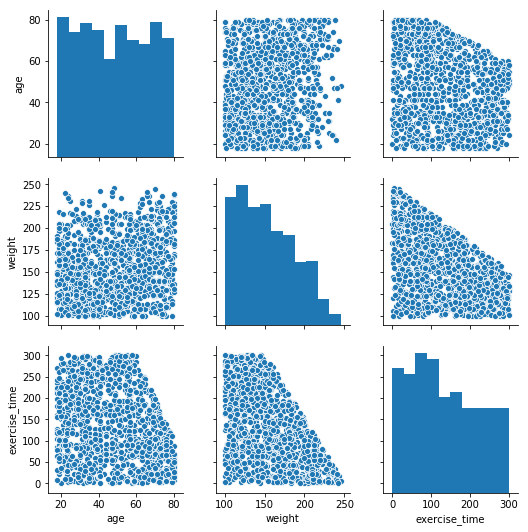

In [34]:
import seaborn as sns
sns.pairplot(df);

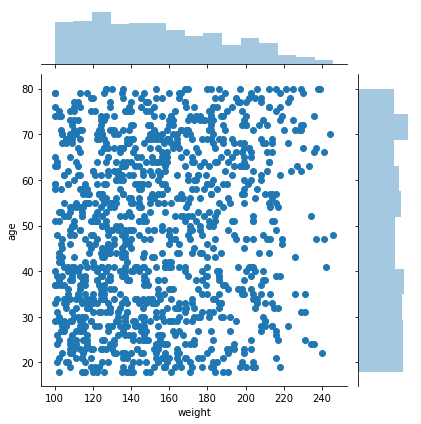

In [39]:
sns.jointplot(x="weight", y="age", data=df);

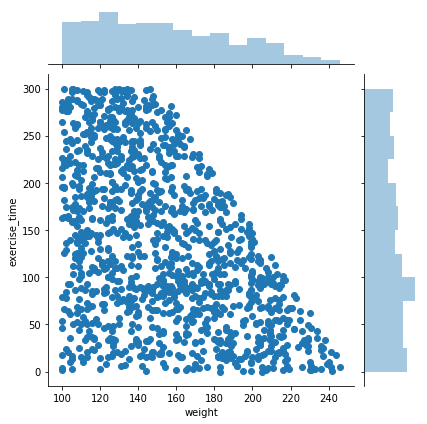

In [40]:
sns.jointplot(x="weight", y="exercise_time", data=df);

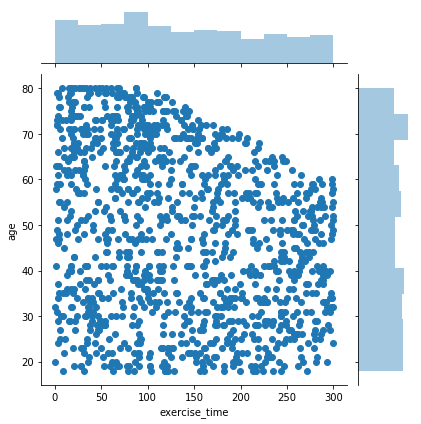

In [71]:
sns.jointplot(x="exercise_time", y="age", data=df);

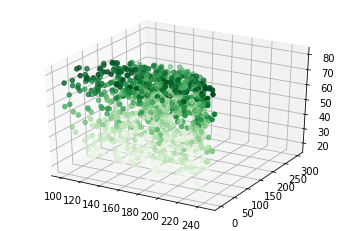

In [61]:
from mpl_toolkits.mplot3d import Axes3D 

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = plt.axes(projection='3d')
zdata = age
xdata = weight
ydata = excercise_time
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');



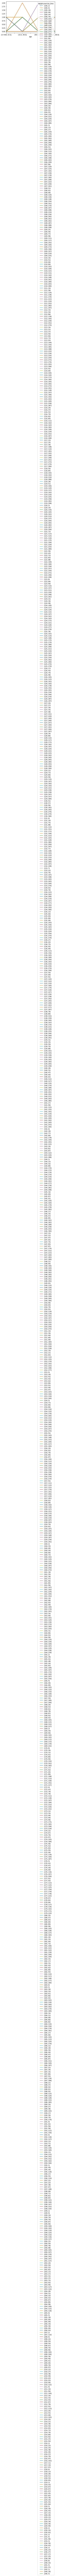

In [69]:
ct.plot();

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

The three main types of data are: dependent, independent and confounding variables.
      
2.  What are the relationships between the variables?

The independent variable and dependent variable are related in terms of cause and effect. The independent variable is changed to observe the changes in the dependent variable. However, the confounding variable is usually an outside factor which influences both the independent and dependent variables.

3.  Which relationships are "real", and which spurious?

Based on the data I can see a "real" relationship between weight (dependent variable) and excercise time (independent variable) with age being spurious to excercise time.


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)